In [1]:
# 宮脇さんコメント
# コードの書き方について
# 関数として使って、マージするか、一個ずつ書くかはどっちでも良い　やりすいほうで
# ↓のコードを参考に見てみてもよい
# https://www.kaggle.com/code/takaito/icr-iarc-gradient-boosting-ensemble-lb-0-22
# ラベルエンコーディングについても学習
# 最寄り駅も抽出した方が
# 間取りも別のやり方でやる事（ディスカッションを覗いてみる）
# CrossValidationのやり方も見直すべき
# OneHotが長い時は次元圧縮しても良い
# SVD scikit learn
# CountEncodingについては、普段Testデータが分かっていないから使う価値がある
# モデルは一個でやるべきか / アンサンブル　/ 複数モデルでも学習できるでは / 次元圧縮
# Neural Net系も使ってみても良いのでは？　Tabnet（モデル）
# importanceを出力してみてImportanceが高いものを加工してみる
# Split  / gain / permutaion(おすすめ)※Collidationが高い時に上手くいかないことがある
# Kerasで実装するとImportanceも出せない
# scikit learnの https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html
# も試してみる価値あり
# pd.unique()も調査

import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from contextlib import contextmanager
from sklearn.preprocessing import LabelEncoder
from time import time

class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

%matplotlib inline

In [2]:
train_df = pd.read_csv("../data/train_utf.csv")
test_df = pd.read_csv("../data/test_utf.csv")

In [3]:
def merge_by_id(left_df, right_df):
    return pd.merge(left_df["ID"], right_df, on="ID", how="left").drop(columns=["ID"])

In [4]:
def create_rent_feature(input_df: pd.DataFrame):
    """input_dfは train or test.csv のデータが入ってくることを想定しています."""

    use_columns = [
        "共益費",
        "敷金/礼金",
        "保証金",
        "専有面積(m2)"
    ]

    return merge_by_id(input_df, train_df)[use_columns]

In [5]:
create_rent_feature(train_df)

,共益費,敷金/礼金,保証金,専有面積(m2)
0,0,1.0,0.000000,18.23
1,0,0.0,0.000000,18.98
2,10000,1.0,1.000000,30.09
3,2000,1.0,1.000000,22.96
4,0,0.0,2.127660,72.06
...,...,...,...,...
65613,6820,0.0,1.288245,21.66
65614,11000,3.0,1.000000,59.76
65615,3000,1.0,1.000000,46.35
65616,7000,0.0,0.000000,24.85


In [6]:
def one_hot_encoding_type(input_df):
    val = "種類"
    out_df = pd.DataFrame()
    target_colname = val
    target_series = input_df[target_colname]
    unique_values = target_series.unique()

    for value in unique_values:
        is_value = target_series == value
        out_df[value] = is_value.astype(int)
    if len (out_df) == len(input_df):
        return out_df
    else:
        return print("something went wrong")

In [7]:
one_hot_encoding_type(train_df)

,賃貸アパート,賃貸マンション,賃貸一戸建て,賃貸テラス・タウンハウス,賃貸その他
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,0,0,1,0,0
...,...,...,...,...,...
65613,0,1,0,0,0
65614,0,1,0,0,0
65615,1,0,0,0,0
65616,0,1,0,0,0


In [8]:
one_hot_encoding_type(test_df)

,賃貸アパート,賃貸マンション,賃貸テラス・タウンハウス,賃貸一戸建て,賃貸その他
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
43744,0,1,0,0,0
43745,0,1,0,0,0
43746,0,1,0,0,0
43747,0,1,0,0,0


In [9]:
# def create_room_type_count_encoding(input_df):
#     count = input_df["間取り"].map(input_df["間取り"].value_counts())
#     encoded_df = pd.DataFrame({
#         "間取り_count": count
#     })

#     return encoded_df

In [10]:
# create_room_type_count_encoding(test_df)

In [11]:
# create_room_type_count_encoding(train_df)

In [12]:
def impute(var01):
    walk = var01[0]
    if pd.isnull(walk):
        return 10
    else:
        return walk


In [13]:
# 階数と年齢を別々にする
def change_floor_year(input_df):
    floor = "階数"
    year = "築年数"
    target_series = input_df[[floor,year]]
    target_series[floor] = target_series[floor].replace("平屋","1階建")
    target_series[floor] = target_series[floor].str.extract(r'(\d+)階建').astype(int)
    target_series[year] = target_series[year].replace("新築","築1年")
    target_series[year] = target_series[year].str.extract(r'(\d+)年').astype(int)

    return target_series



In [14]:
change_floor_year(test_df)

<ipython-input-13-112749881604>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_series[floor] = target_series[floor].replace("平屋","1階建")
<ipython-input-13-112749881604>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_series[floor] = target_series[floor].str.extract(r'(\d+)階建').astype(int)
<ipython-input-13-112749881604>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,階数,築年数
0,3,10
1,11,3
2,3,40
3,4,55
4,5,16
...,...,...
43744,8,21
43745,5,45
43746,13,19
43747,7,24


In [15]:
train_df_02=pd.DataFrame()
train_df_02[["最寄り駅","徒歩"]] =train_df["最寄り駅1"].str.extract(r'([^/]+) 歩(\d+)分')
train_df_02["間取り"]=train_df["間取り"]
test_df_02=pd.DataFrame()
test_df_02[["最寄り駅","徒歩"]] =test_df["最寄り駅1"].str.extract(r'([^/]+) 歩(\d+)分')
test_df_02["間取り"]=test_df["間取り"]


In [16]:
print(train_df_02.nunique(),test_df_02.nunique())

最寄り駅    1357
徒歩        66
間取り       39
dtype: int64 最寄り駅    1206
徒歩        61
間取り       37
dtype: int64


In [17]:
test_df_02.nunique()

最寄り駅    1206
徒歩        61
間取り       37
dtype: int64

In [18]:
test_df_02["間取り"] = test_df_02["間取り"].replace('7SK',"5LDK")
test_df_02["間取り"] = test_df_02["間取り"].replace('7SDK',"5LDK")
test_df_02["間取り"] = test_df_02["間取り"].replace('4SK',"4LDK")

In [19]:
def encode_categorical(df01,df02):
    cols =["間取り"]
    out_test_df = pd.DataFrame()
    out_train_df = pd.DataFrame()
    for col in cols:
        le = LabelEncoder()
        le.fit(df01[col])
        df01[col] = le.transform(df01[col])
        df02[col] = le.transform(df02[col])
        out_train_df[col] =df01[col]
        out_test_df[col] = df02[col]
    return out_train_df[cols],out_test_df[cols]

In [20]:
train_df_02["間取り"], test_df_02["間取り"] = encode_categorical(train_df_02,test_df_02)

In [21]:
def label_encode_categorical_column(train_df, test_df, column_name):
    # Combine train and test data
    combined_data = pd.concat([train_df, test_df])

    # Apply label encoding to combined data
    le = LabelEncoder()
    combined_data[column_name] = le.fit_transform(combined_data[column_name])

    # Split combined data back into train and test data
    train_encoded = combined_data.iloc[:len(train_df)]
    test_encoded = combined_data.iloc[len(train_df):]

    return train_encoded[column_name], test_encoded[column_name]


In [22]:
train_df_02["最寄り駅"], test_df_02["最寄り駅"] = label_encode_categorical_column(train_df_02, test_df_02, "最寄り駅")

In [23]:
test_df_02

,最寄り駅,徒歩,間取り
0,867,3,3
1,1350,3,1
2,841,4,38
3,577,1,3
4,815,3,3
...,...,...,...
43744,1353,3,2
43745,1292,20,3
43746,481,5,2
43747,1132,4,2


In [24]:
train_df_02

,最寄り駅,徒歩,間取り
0,1350,12,2
1,533,4,2
2,124,3,11
3,1519,9,2
4,1208,3,12
...,...,...,...
65613,473,4,2
65614,301,5,10
65615,552,8,3
65616,1170,10,2


In [25]:
# def encode_categorical(df,cols):
#   for col in cols:
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])
#   return df

In [26]:
# train_df_02 = encode_categorical(train_df_02,cols = ["最寄り駅"])

In [27]:
# test_df_02 = encode_categorical(test_df_02,cols = ["最寄り駅"])

In [28]:
def impute(var01):
    walk = var01[0]
    if pd.isnull(walk):
        return 10
    else:
        return walk


In [29]:
train_df_02["徒歩"] = train_df_02[["徒歩"]].apply(impute,axis=1)
train_df_02["徒歩"] = train_df_02["徒歩"].astype(int)

In [30]:
test_df_02["徒歩"] = test_df_02[["徒歩"]].apply(impute,axis=1)
test_df_02["徒歩"] = test_df_02["徒歩"].astype(int)

In [31]:
def one_hot_encoding(input_df,val):
    out_df = pd.DataFrame()
    target_colname = val
    target_series = input_df[target_colname]
    unique_values = target_series.unique()

    for value in unique_values:
        is_value = target_series == value
        out_df[value] = is_value.astype(int)
    if len (out_df) == len(input_df):
        return out_df
    else:
        return print("something went wrong")

In [32]:
def create_state(input_df):
    out_df = pd.DataFrame()
    country = "都道府県"
    state = "区"
    address = "住所"
    out_df[[country,state]] =input_df[address].str.split('都|県|道|府|市|区', expand=True).iloc[:, [0, -1]]
  #　TODO見直し
    out_df.drop("区",axis=1,inplace = True)
    return one_hot_encoding(out_df,"都道府県")

In [33]:
create_state(train_df)

,東京,大阪,愛知,宮城,北海
0,1,0,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
65613,0,1,0,0,0
65614,0,0,0,1,0
65615,1,0,0,0,0
65616,0,0,1,0,0


In [34]:
def create_feature(input_df):

    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_rent_feature,
        one_hot_encoding_type,
        change_floor_year,
        create_state
    ]

    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        with Timer(prefix=f"create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [35]:
with Timer(prefix="train..."):
    train_feat_df = create_feature(train_df)

with Timer(prefix="test..."):
    test_feat_df = create_feature(test_df)

X = train_feat_df
y = train_df["賃料"].values

create create_rent_feature 0.043[s]
create one_hot_encoding_type 0.023[s]
create change_floor_year 0.154[s]


<ipython-input-13-112749881604>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_series[floor] = target_series[floor].replace("平屋","1階建")
<ipython-input-13-112749881604>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_series[floor] = target_series[floor].str.extract(r'(\d+)階建').astype(int)
<ipython-input-13-112749881604>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

create create_state 0.177[s]
train... 0.408[s]
create create_rent_feature 0.032[s]
create one_hot_encoding_type 0.020[s]
create change_floor_year 0.114[s]
create create_state 0.114[s]
test... 0.288[s]


In [36]:
X = X.join(train_df_02,how ="left")

In [37]:
# X = X.values
X.dtypes

共益費               int64
敷金/礼金           float64
保証金             float64
専有面積(m2)        float64
賃貸アパート            int64
賃貸マンション           int64
賃貸一戸建て            int64
賃貸テラス・タウンハウス      int64
賃貸その他             int64
階数                int64
築年数               int64
東京                int64
大阪                int64
愛知                int64
宮城                int64
北海                int64
最寄り駅              int64
徒歩                int64
間取り               int64
dtype: object

In [38]:
test_feat_df.dtypes

共益費               int64
敷金/礼金           float64
保証金             float64
専有面積(m2)        float64
賃貸アパート            int64
賃貸マンション           int64
賃貸テラス・タウンハウス      int64
賃貸一戸建て            int64
賃貸その他             int64
階数                int64
築年数               int64
愛知                int64
東京                int64
宮城                int64
大阪                int64
北海                int64
dtype: object

In [39]:
test_feat_df = test_feat_df.join(test_df_02, how = "left")

In [40]:
list01 = list(X.columns)

In [41]:
list01 

['共益費',
 '敷金/礼金',
 '保証金',
 '専有面積(m2)',
 '賃貸アパート',
 '賃貸マンション',
 '賃貸一戸建て',
 '賃貸テラス・タウンハウス',
 '賃貸その他',
 '階数',
 '築年数',
 '東京',
 '大阪',
 '愛知',
 '宮城',
 '北海',
 '最寄り駅',
 '徒歩',
 '間取り']

In [42]:
test_feat_df = test_feat_df.reindex(columns =list01)

In [43]:
test_feat_df

,共益費,敷金/礼金,保証金,専有面積(m2),賃貸アパート,賃貸マンション,賃貸一戸建て,賃貸テラス・タウンハウス,賃貸その他,階数,築年数,東京,大阪,愛知,宮城,北海,最寄り駅,徒歩,間取り
0,0,1.0,0.00000,18.23,1,0,0,0,0,3,10,0,0,1,0,0,867,3,3
1,0,0.0,0.00000,18.98,0,1,0,0,0,11,3,1,0,0,0,0,1350,3,1
2,10000,1.0,1.00000,30.09,0,1,0,0,0,3,40,1,0,0,0,0,841,4,38
3,2000,1.0,1.00000,22.96,0,1,0,0,0,4,55,1,0,0,0,0,577,1,3
4,0,0.0,2.12766,72.06,0,1,0,0,0,5,16,0,0,0,1,0,815,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43744,0,0.0,1.00000,23.83,0,1,0,0,0,8,21,1,0,0,0,0,1353,3,2
43745,10000,1.0,1.00000,31.64,0,1,0,0,0,5,45,1,0,0,0,0,1292,20,3
43746,0,1.0,1.00000,40.95,0,1,0,0,0,13,19,1,0,0,0,0,481,5,2
43747,2000,1.0,1.00000,22.00,0,1,0,0,0,7,24,1,0,0,0,0,1132,4,2


In [44]:
X

,共益費,敷金/礼金,保証金,専有面積(m2),賃貸アパート,賃貸マンション,賃貸一戸建て,賃貸テラス・タウンハウス,賃貸その他,階数,築年数,東京,大阪,愛知,宮城,北海,最寄り駅,徒歩,間取り
0,0,1.0,0.000000,18.23,1,0,0,0,0,2,27,1,0,0,0,0,1350,12,2
1,0,0.0,0.000000,18.98,0,1,0,0,0,10,34,0,1,0,0,0,533,4,2
2,10000,1.0,1.000000,30.09,0,1,0,0,0,10,16,1,0,0,0,0,124,3,11
3,2000,1.0,1.000000,22.96,1,0,0,0,0,2,18,1,0,0,0,0,1519,9,2
4,0,0.0,2.127660,72.06,0,0,1,0,0,2,49,0,1,0,0,0,1208,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65613,6820,0.0,1.288245,21.66,0,1,0,0,0,15,2,0,1,0,0,0,473,4,2
65614,11000,3.0,1.000000,59.76,0,1,0,0,0,12,36,0,0,0,1,0,301,5,10
65615,3000,1.0,1.000000,46.35,1,0,0,0,0,2,16,1,0,0,0,0,552,8,3
65616,7000,0.0,0.000000,24.85,0,1,0,0,0,15,1,0,0,1,0,0,1170,10,2


In [45]:
X = X.values

In [46]:
from sklearn.model_selection import KFold
fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(X, y))
# もともとが generator なため明示的に list に変換する
# oof, models = fit_lgbm(X, y, cv, params=params, verbose=500)


In [47]:
from sklearn.metrics import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    """mean_squared_error の root (0.5乗)"""
    return mean_squared_error(y_true, y_pred) ** .5

In [48]:
import lightgbm as lgbm

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix="fit fold={} ".format(i)):

            # cv 内で train に定義された x_train で学習する
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        # cv 内で validation data とされた x_valid で予測をして oof_pred に保存していく
        # oof_pred は全部学習に使わなかったデータの予測結果になる → モデルの予測性能を見る指標として利用できる
        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = root_mean_squared_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = root_mean_squared_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return oof_pred, models

In [49]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    "objective": "rmse", 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    "n_estimators": 10000, 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    "learning_rate": .1,

    # 特徴重要度計算のロジック(後述)
    "importance_type": "gain", 
    "random_state": 510,
}

oof, models = fit_lgbm(X, y=y, params=params, cv=cv)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 10940.8
[100]	valid_0's rmse: 10127.7
[150]	valid_0's rmse: 9748.47
[200]	valid_0's rmse: 9552.02
[250]	valid_0's rmse: 9376.79
[300]	valid_0's rmse: 9244.85
[350]	valid_0's rmse: 9151.76
[400]	valid_0's rmse: 9056.14
[450]	valid_0's rmse: 8960.52
[500]	valid_0's rmse: 8893.58
[550]	valid_0's rmse: 8823.02
[600]	valid_0's rmse: 8757.15
[650]	valid_0's rmse: 8696.72
[700]	valid_0's rmse: 8657.18
[750]	valid_0's rmse: 8610.47
[800]	valid_0's rmse: 8576.08
[850]	valid_0's rmse: 8543.05
[900]	valid_0's rmse: 8519.23
[950]	valid_0's rmse: 8487.18
[1000]	valid_0's rmse: 8455.57
[1050]	valid_0's rmse: 8434.75
[1100]	valid_0's rmse: 8409.71
[1150]	valid_0's rmse: 8385.76
[1200]	valid_0's rmse: 8363.01
[1250]	valid_0's rmse: 8340.08
[1300]	valid_0's rmse: 8320.61
[1350]	valid_0's rmse: 8308.7
[1400]	valid_0's rmse: 8291.77
[1450]	valid_0's rmse: 8277.85
[1500]	valid_0's rmse: 8264.45
[1550]	valid_0's rmse: 8250.7

In [50]:
root_mean_squared_error(y_true=y, y_pred=oof)

8078.441016123192

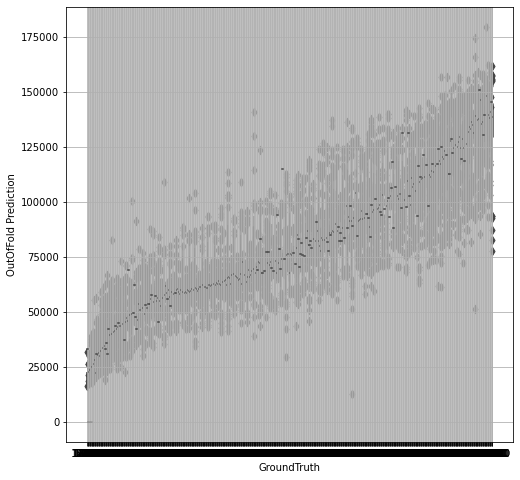

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.boxenplot(data=pd.DataFrame({ "GroundTruth": y, "OutOfFold Prediction": oof }), 
              x="GroundTruth", y="OutOfFold Prediction", ax=ax)

ax.grid()
ax.plot([0, 9], [1, 10], "--", c="black", alpha=.2)

In [52]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

In [53]:
# fig, ax = visualize_importance(models, train_feat_df)

In [54]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test_feat_df.values) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0) 

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


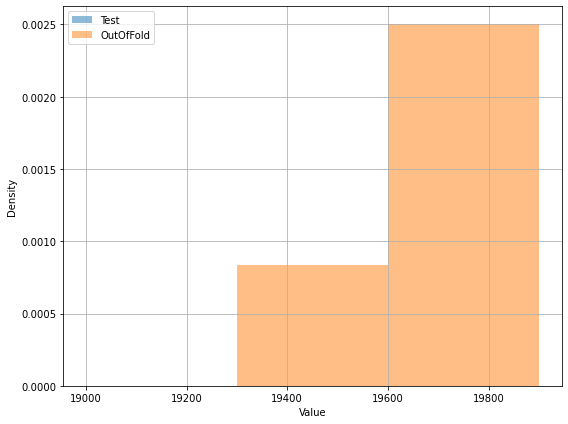

In [62]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Define the bin range and width
bin_range = (19000, 20000)
bin_width = 300  # Adjust this based on your data and preference

# Create histograms
hist_pred, bins_pred, _ = ax.hist(pred, bins=np.arange(*bin_range, bin_width), density=True, alpha=0.5, label="Test")
hist_oof, bins_oof, _ = ax.hist(oof, bins=np.arange(*bin_range, bin_width), density=True, alpha=0.5, label="OutOfFold")

# Set the y-axis scale (density)
ax.set_ylabel("Density")

# Set the x-axis label
ax.set_xlabel("Value")

# Add a legend
ax.legend()

# Add a grid
ax.grid()

# Set the title if needed
# ax.set_title("Histogram of Predictions")

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


In [57]:
pd.DataFrame({
    "ID":test_df["ID"],
    "predict": pred
}).to_csv(os.path.join("./OUTPUT_DIR", "#8__submission.csv"), index=False)